In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

Using TensorFlow backend.


In [21]:
import keras
keras.__version__

'2.0.5'

In [2]:
np.random.seed(42)

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

10903552/11490434 [===========================>..] - ETA: 0s 

Картинки 24х24, развернем каждую в вектор длины 784.

In [4]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32')

Масштабируем данные.

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [8]:
y_train[:3, :]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [9]:
model = Sequential()

In [12]:
model.add(Dense(800, input_dim=784, kernel_initializer='normal', activation='relu'))

In [13]:
model.add(Dense(10, kernel_initializer='normal', activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8010      
_________________________________________________________________
dense_3 (Dense)              (None, 800)               8800      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                8010      
Total params: 652,820
Trainable params: 652,820
Non-trainable params: 0
_________________________________________________________________
None


Визуализация модели (нужно выполнить pip install pydot-ng)

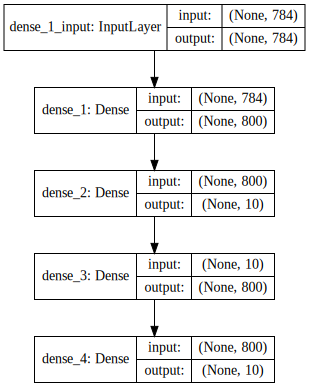

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Callbacks
### Ранняя остановка
Нужно также сказать несколько слов о такой важной особенности Keras, как колбеки. Через них реализовано много полезной функциональности. Например, если вы тренируете сеть в течение очень долгого времени, вам нужно понять, когда пора остановиться, если ошибка на вашем датасете перестала уменьшаться. По-английски описываемая функциональность называется "early stopping" ("ранняя остановка").

In [19]:
from keras.callbacks import EarlyStopping  
early_stopping = EarlyStopping(monitor='loss')

### Tensorboard
Еще в качестве колбека можно использовать сохранение логов в формате, удобном для Tensorboard — это специальная утилита для обработки и визуализации информации из логов Tensorflow.
После того, как обучение закончится (или даже в процессе!), вы можете запустить Tensorboard, указав абсолютный путь к директории с логами:
tensorboard --logdir=/path/to/logs

In [20]:
from keras.callbacks import TensorBoard  
tensorboard = TensorBoard(log_dir='../logs/', write_graph=True)

In [ ]:
%%time
model.fit(X_train_scaled, y_train, batch_size=200, epochs=100, 
          validation_split=0.2, callbacks=[early_stopping, tensorboard], verbose=2);

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
4s - loss: 0.5569 - acc: 0.8703 - val_loss: 0.6286 - val_acc: 0.8392
Epoch 2/100
4s - loss: 0.5331 - acc: 0.8825 - val_loss: 0.6521 - val_acc: 0.8056
Epoch 3/100
4s - loss: 0.5124 - acc: 0.8879 - val_loss: 0.5859 - val_acc: 0.8623
Epoch 4/100
4s - loss: 0.4892 - acc: 0.8970 - val_loss: 0.5624 - val_acc: 0.8705
Epoch 5/100
4s - loss: 0.4695 - acc: 0.9018 - val_loss: 0.5454 - val_acc: 0.8783
Epoch 6/100


C помощью Tensorboard удобно отслеживать процесс обучения нейронной сети. 

<img src='../img/tensorboard_mnist.png'>

Оцениваем качество обучения сети на тестовых данных

In [ ]:
scores = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Доля верных ответов на тестовых данных: %.2f%%" % (scores[1]*100))

## Сохраняем сеть
**Архитектуру – в JSON-файл**

In [ ]:
model_json = model.to_json()
with open("mnist_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import pprint
import json

In [ ]:
with open("mnist_model.json", "r") as json_file:
    pprint.pprint(json.loads(json_file.read()))

**Веса сохраняем в бинарный hd5-файл**

In [ ]:
model.save_weights("mnist_model.h5")

**Теперь сеть можно восстановить и использовать**

In [ ]:
from keras.models import model_from_json

with open("mnist_model.json") as json_file:
    loaded_model_json = json_file.read()

# Создаем модель на основе загруженных данных
loaded_model = model_from_json(loaded_model_json)
# Загружаем веса в модель
loaded_model.load_weights("mnist_model.h5")

Перед использованием модели ее обязательно нужно скомпилировать. 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
scores = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Доля верных ответов на тестовых данных: %.2f%%" % (scores[1]*100))